In [28]:
import pynucastro as pyna
import matplotlib.pyplot as plt
import numpy as np
from pynucastro.screening import potekhin_1998
from scipy.integrate import solve_ivp

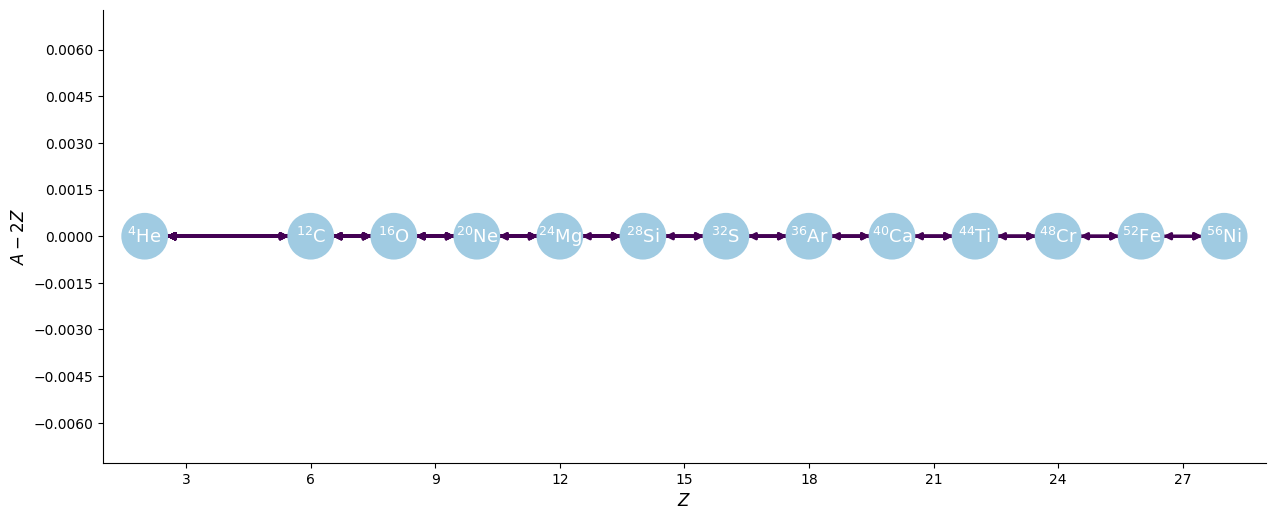

In [29]:
rl = pyna.ReacLibLibrary()

all_nuclei = ['he4', 'c12', 'o16', 'ne20', 'mg24', 'si28', 's32', 'ar36', 'ca40', 'ti44', 'cr48', 'fe52', 'ni56']

fwd = rl.linking_nuclei(nuclist=all_nuclei, with_reverse=False)

inv = []
for r in fwd.get_rates():
    if not r.weak:
        t = pyna.DerivedRate(r, compute_Q=False, use_pf=True)
        inv.append(t)

inv = pyna.Library(rates=inv)

tot = fwd + inv
rc = pyna.PythonNetwork(libraries=tot, symmetric_screening=False, do_screening=True)
rc.plot(rotated=True, size=(1500,600), curved_edges=False)
rc.write_network('approx13.py')

In [38]:
print(tot)

He4 + He4 + He4 ⟶ C12 + 𝛾      [Q =   7.28 MeV] (he4 + he4 + he4 --> c12 <fy05_reaclib__>)
C12 ⟶ He4 + He4 + He4          [Q =  -7.28 MeV] (c12 --> he4 + he4 + he4 <derived_reaclib__>)
C12 + He4 ⟶ O16 + 𝛾            [Q =   7.16 MeV] (c12 + he4 --> o16 <nac2_reaclib__>)
C12 + C12 ⟶ He4 + Ne20         [Q =   4.62 MeV] (c12 + c12 --> he4 + ne20 <cf88_reaclib__>)
O16 ⟶ He4 + C12                [Q =  -7.16 MeV] (o16 --> he4 + c12 <derived_reaclib__>)
O16 + He4 ⟶ Ne20 + 𝛾           [Q =   4.73 MeV] (o16 + he4 --> ne20 <co10_reaclib__>)
O16 + C12 ⟶ He4 + Mg24         [Q =   6.77 MeV] (o16 + c12 --> he4 + mg24 <cf88_reaclib__>)
O16 + O16 ⟶ He4 + Si28         [Q =   9.59 MeV] (o16 + o16 --> he4 + si28 <cf88_reaclib__>)
Ne20 + He4 ⟶ C12 + C12         [Q =  -4.62 MeV] (ne20 + he4 --> c12 + c12 <derived_reaclib__>)
Ne20 ⟶ He4 + O16               [Q =  -4.73 MeV] (ne20 --> he4 + o16 <derived_reaclib__>)
Ne20 + He4 ⟶ Mg24 + 𝛾          [Q =   9.32 MeV] (ne20 + he4 --> mg24 <il10_reaclib__>)
Ne20 + C1

In [30]:
import approx13

In [31]:
X0 = np.zeros(approx13.nnuc)
X0[approx13.jhe4] = 1.0
X0[approx13.jc12] = 0.0
X0[approx13.jo16] = 0.0
X0[approx13.jne20] = 0.0
X0[approx13.jmg24] = 0.0
X0[approx13.jsi28] = 0.0
X0[approx13.js32] = 0.0
X0[approx13.jar36] = 0.0
X0[approx13.jca40] = 0.0
X0[approx13.jti44] = 0.0
X0[approx13.jcr48] = 0.0
X0[approx13.jfe52] = 0.0
X0[approx13.jni56] = 0.0

X0 /= np.sum(X0)
Y0 = X0/approx13.A

In [32]:
rho = 1.0e8 
T = 7.0e9
Ye = approx13.ye(Y0)

In [33]:
tmin = 1.0e-9
tmax = 3.0e-2
sol =  solve_ivp(approx13.rhs, [0, tmax], Y0, method="BDF",
                dense_output=True, args=(rho, T, potekhin_1998), rtol=1.e-10, atol=1.e-10, jac=approx13.jacobian)

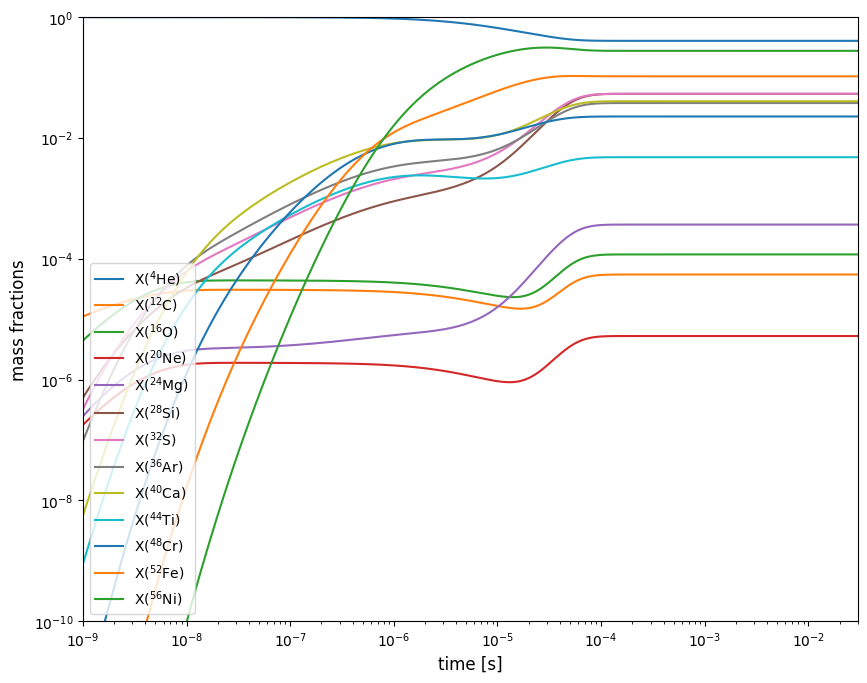

In [34]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for i in range(approx13.nnuc):
    ax.loglog(sol.t, sol.y[i,:] * approx13.A[i], label=rf"X(${pyna.Nucleus(approx13.names[i]).pretty}$)")

ax.set_xlim(tmin, tmax)
ax.legend(loc="lower left")
ax.set_ylim(1.e-10, 1.0)
ax.set_xlabel(f"time [s]", fontsize=12)
ax.set_ylabel(f"mass fractions", fontsize=12)
fig.set_size_inches((10, 8))

In [36]:
comp = rc.get_comp_nse(rho, T, Ye, init_guess=(-3.5, -14.0), use_coulomb_corr=True)

print("From NSE calculation:")
print(comp)
# for key, value in comp.items():
#     print(key, ":", value)

print(" ")

print("From integration:")
for i in range(approx13.nnuc):
    print(f"X({approx13.names[i]}): {sol.y[i,-1]*approx13.A[i]}")

From NSE calculation:
  X(he4) : 0.4054355379334854
  X(c12) : 5.482045817664568e-05
  X(o16) : 0.00011779421225009412
  X(ne20) : 5.247318671709445e-06
  X(mg24) : 0.0003670615663825952
  X(si28) : 0.053526008885845786
  X(s32) : 0.05373088981323158
  X(ar36) : 0.03773396480957948
  X(ca40) : 0.04038524419715561
  X(ti44) : 0.0047837524350673915
  X(cr48) : 0.022671498182469742
  X(fe52) : 0.10405890685663662
  X(ni56) : 0.27712927333141985

 
From integration:
X(he4): 0.4048866565440253
X(c12): 5.475470447226996e-05
X(o16): 0.00011780163370023063
X(ne20): 5.25039383414433e-06
X(mg24): 0.0003675950386755799
X(si28): 0.0536315723977941
X(s32): 0.053874579607158406
X(ar36): 0.03783690206346638
X(ca40): 0.04050413295766206
X(ti44): 0.004798916098188206
X(cr48): 0.0226491425093478
X(fe52): 0.10469993753716463
X(ni56): 0.27657275824341876


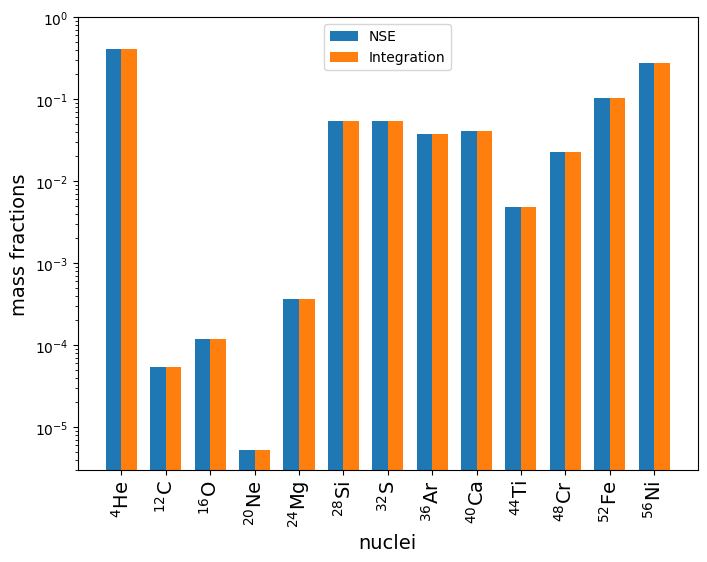

In [37]:
# Bar graph for visual

x = np.arange(len(approx13.names))
width = 0.35

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.bar(x - width/2.0, list(comp.X.values()), width, label = 'NSE')
ax.bar(x + width/2.0, sol.y[:,-1] * approx13.A, width, label = 'Integration')
ax.set_xlabel("nuclei", fontsize=14)
ax.set_xticks(x, labels=[f"${n.pretty}$" for n in comp.X.keys()], rotation=90, fontsize=14)
ax.set_ylabel("mass fractions", fontsize=14)
ax.legend(fontsize=14)
ax.set_yscale("log")
ax.set_ylim(ymax = 1)
ax.legend()
